# Excercise: Eigen Face

Here, we will look into ability of PCA to perform dimensionality reduction on a set of Labeled Faces in the Wild dataset made available from scikit-learn. Our images will be of shape (62, 47). This problem is also famously known as the eigenface problem. Mathematically, we would like to find the principal components (or eigenvectors) of the covariance matrix of the set of face images. These eigenvectors are essentially a set of orthonormal features depicts the amount of variation between face images. When plotted, these eigenvectors are called eigenfaces.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from sklearn.datasets import fetch_lfw_people

import seaborn as sns
sns.set()

## Setup data

In [2]:
faces = fetch_lfw_people(min_faces_per_person=8)
X = faces.data
y = faces.target

## Helper functions to plot faces

In [3]:
# plot one face given
def plot_face(face):
    plt.imshow(face.reshape(62, 47), cmap='binary_r')

In [4]:
# plots 20 faces from the given set
def plot_20faces(faces):
    fig, axes = plt.subplots(2, 10, figsize=(10, 2.5),
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(faces[i].reshape(62, 47), cmap='binary_r')

In [5]:
# plots first 10 faces from the given set
def plot_10faces(faces):
    fig, axes = plt.subplots(1, 10, figsize=(10, 2.5),
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(faces[i].reshape(62, 47), cmap='binary_r')

# IMPLEMENTATION OF EIGENFACES

In [6]:
data_matrix = X

## Understanding the dimensions of the data

In [7]:
N = data_matrix.shape[0]  # number of faces
d = data_matrix.shape[1]  # number of features

print(data_matrix.shape)

(4822, 2914)


#### Plotting first 20 faces

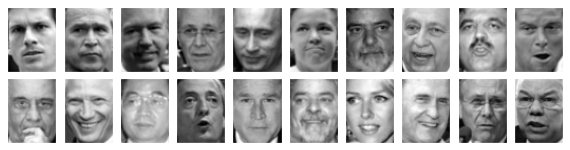

In [8]:
plot_20faces(data_matrix)

## STEP 1: STANDARDIZATION BY REMOVING THE MEAN

In [9]:
data_matrix_mean = np.mean(data_matrix, axis=0, keepdims=True)
data_matrix_centralised = data_matrix - data_matrix_mean

#### Plot of an average face

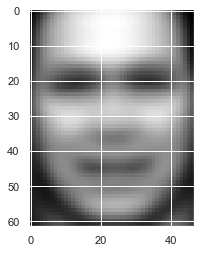

In [10]:
plot_face(data_matrix_mean)

## STEP 2: CALCULATING THE COVARIANCE MATRIX

In [11]:
covariance_matrix = 1/N * data_matrix_centralised.T @ data_matrix_centralised

#### Checking the shape of the covariance matrix

In [12]:
covariance_matrix.shape

(2914, 2914)

as expected, the shape is d x d

## STEP 2.1: EIGEN DECOMPOSITION OF COVARIANCE MATRIX

In [13]:
lambdas, V = np.linalg.eig(covariance_matrix)

#### Calculating the shape of lambdas and V

In [14]:
V.shape, lambdas.shape

((2914, 2914), (2914,))

each column of V contains an eigenvector of the covariance matrix, corresponding to lambdas

### STEP 2.1.1: Making the values to non-increasing order

In [15]:
# np.argsort: returns the indices one would use to sort the array; use this for reordering lambdas and V
idx = lambdas.argsort()[::-1]
lambdas = np.real(lambdas[idx])
V = np.real(V[:, idx])

#### Graph of lambdas

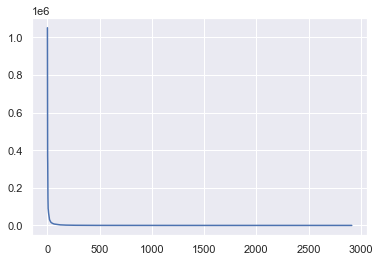

In [16]:
plt.plot(lambdas)

from the plot, we see that the values of lambda suddenly diminishes (from 10<sup>6</sup> to 0). Hence only really few features are important

## STEP 3: DETERMINING THE VALUE OF K

We can determine the value of k as follows:
- in the lambdas array arranged in non-decreasing order, 
- increment k till the current sum becomes larger than the required 95 % of total sum

In [17]:
k = 0
total = np.sum(lambdas)
current_sum = 0
for i in lambdas:
    k += 1
    current_sum += i
    if(current_sum/total > 0.95):
        break
print(k)

178


Hence we must choose k = 178, i.e. 178 top eigenvectors, if we need have 95% of the variance to be preserved

#### Plot of the variance preserved with increasing k

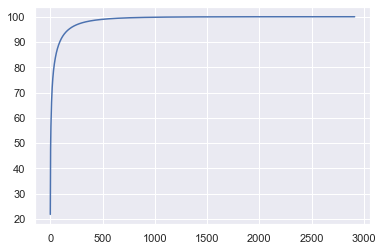

In [18]:
variance_preserved = []
total = np.sum(lambdas)
current_sum = 0
for i in lambdas:
    current_sum += i
    variance_preserved.append((current_sum*100)/total)
plt.plot(variance_preserved)

Here, we can see that increasing k does not change the situation much, after, say 500 or so

### STEP 3.1: Since asked, we choose only choose 100 top eigenvalues. hence changing k,

In [19]:
k = 100

## STEP 4: PCA FOR THE DATA MATRIX

### STEP 4.1: Trimming V

We need only the first k eigenvectors of V.
Since eigenvectors of V are along the columns (each column represents an eigenvector), we throw away some columns in this step

In [20]:
new_V = V[:, :k]

In [21]:
new_V.shape

(2914, 100)

As expected, V has only k columns

### STEP 4.2: Getting the new representation of the data matrix

In [22]:
compressed_data_matrix = data_matrix_centralised @ new_V

In [23]:
compressed_data_matrix.shape

(4822, 100)

We have successfully done PCA compression on these images and reduced their feature set to just k top values

## STEP 5: RECONSTRUCTION FROM PCA

In [24]:
reconstructed_data_matrix = compressed_data_matrix @ new_V.T + data_matrix_mean

### STEP 5.1: comparing the two face sets

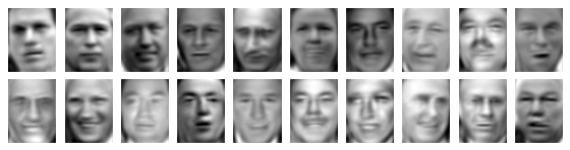

In [25]:
#### reconstructed
plot_20faces(reconstructed_data_matrix)

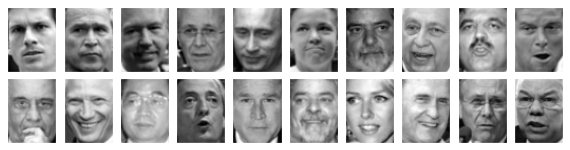

In [26]:
#### original
plot_20faces(data_matrix)

# FUNCTION THAT DOES EVERYTHING

In [27]:
def show_both_answers(data_matrix):
    # STEP 1: STANDARDIZATION BY REMOVING THE MEAN
    data_matrix_mean = np.mean(data_matrix, axis=0, keepdims=True)
    data_matrix_centralised = data_matrix - data_matrix_mean
    # STEP 2: CALCULATING THE COVARIANCE MATRIX
    N = data_matrix.shape[0]
    covariance_matrix = 1/N * data_matrix_centralised.T @ data_matrix_centralised
    # STEP 2.1: EIGEN DECOMPOSITION OF COVARIANCE MATRIX
    lambdas, V = np.linalg.eig(covariance_matrix)
    # Making the values to non-increasing order
    idx = lambdas.argsort()[::-1]
    lambdas = np.real(lambdas[idx])
    V = np.real(V[:, idx])

    # STEP 3: DETERMINING THE VALUE OF K (QUESTION 1)
    k = 0
    total = np.sum(lambdas)
    current_sum = 0
    for i in lambdas:
        k += 1
        current_sum += i
        if(current_sum/total > 0.95):
            break
    print("Answer 1: The number of principal components required such that 95% of the variance in the data is preserved = ", k)

    k = 100  # choosing only 100 top components, since asked

    # STEP 4: PCA FOR THE DATA MATRIX
    new_V = V[:, :k]  # Trimming V
    # Getting the new representation of the data matrix
    compressed_data_matrix = data_matrix_centralised @ new_V

    # STEP 5: RECONSTRUCTION FROM PCA (QUESTION 2)
    reconstructed_data_matrix = compressed_data_matrix @ new_V.T + data_matrix_mean
    print("Answer 2: The reconstruction of the first 10 face images using only 100 principal components.")
    print("The first row shows the original set of faces, while the second row shows the reconstructed set of faces: ")
    plot_10faces(data_matrix)
    plot_10faces(reconstructed_data_matrix)

# IMPLEMENTATION OF EIGENFACES ON THE ORIGINAL DATA

Answer 1: The number of principal components required such that 95% of the variance in the data is preserved =  178
Answer 2: The reconstruction of the first 10 face images using only 100 principal components.
The first row shows the original set of faces, while the second row shows the reconstructed set of faces: 


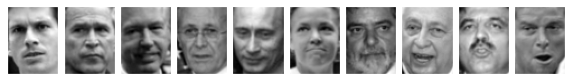

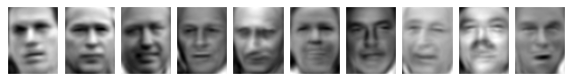

In [28]:
show_both_answers(X)

# IMPLEMENTATION OF EIGENFACES ON THE NOISY DATA

## Adding noise to images

We now add gaussian noise to the images. Will PCA be able to effectively perform dimensionality reduction

Below we plot first twenty noisy input face images.

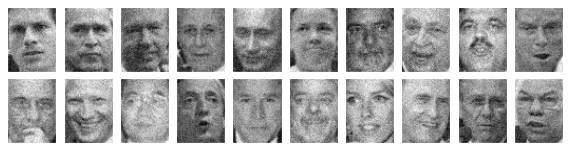

In [29]:
np.random.seed(42)
noisy_faces = np.random.normal(X, 15)
plot_20faces(noisy_faces)

Answer 1: The number of principal components required such that 95% of the variance in the data is preserved =  1014
Answer 2: The reconstruction of the first 10 face images using only 100 principal components.
The first row shows the original set of faces, while the second row shows the reconstructed set of faces: 


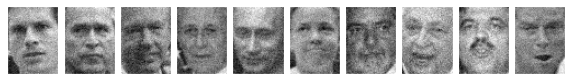

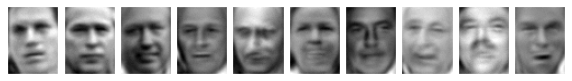

In [30]:
show_both_answers(noisy_faces)